In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_unitary

import QuantumReservoirpy as QRP
from QuantumReservoirpy.utilities import memory_to_mean

from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Setup of circuits
mem_qubits = [0, 1, 2]
timeseries = [0, 1, 2] * 10
ops = [random_unitary(2**len(mem_qubits)) for _ in range(len(np.unique(timeseries)))]


# Backwards horizon (M) needed to cover 95% (r) of all cases
M = 5
r = 0.95

# Dissipation
d =  (1 - r)**(1/M)
d = 0.9
print("Dissipation: ", d)

# Number of different circuits (different due to randomness)
SHOTS = 1000
num_subsystems = 20
subsystems = [0] * num_subsystems

n_features = len(mem_qubits)
results = np.zeros((len(timeseries), n_features))

for idx in tqdm(range(num_subsystems)):
    for l in range(2*M, len(timeseries)):
        qr = QuantumRegister(len(mem_qubits))
        cr = ClassicalRegister(len(mem_qubits))
        circ = QuantumCircuit(qr, cr)
        circ.reset(qr)

        for i, time in enumerate(timeseries[l-2*M:l]):
            circ.unitary(ops[time], qr, label=f'{time}')
            circ.measure(0, 0)
            if np.random.random() > d:
                circ.reset(qr)
        circ.measure(qr, cr)

        counts = QRP.utilities.simulate(circ, shots=SHOTS)#.get_counts()
        # counts = [elem.replace(" ", "") for elem in counts]
        res = memory_to_mean(counts, 1).ravel()
        results[l] += res.copy()
        subsystems[idx] = circ

results /= (num_subsystems)

Dissipation:  0.9


100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


(29, 3)
Score of model: 0.42857142857142855


(<Figure size 2000x2000 with 4 Axes>, <Axes: title={'center': 'Feature 3'}>)

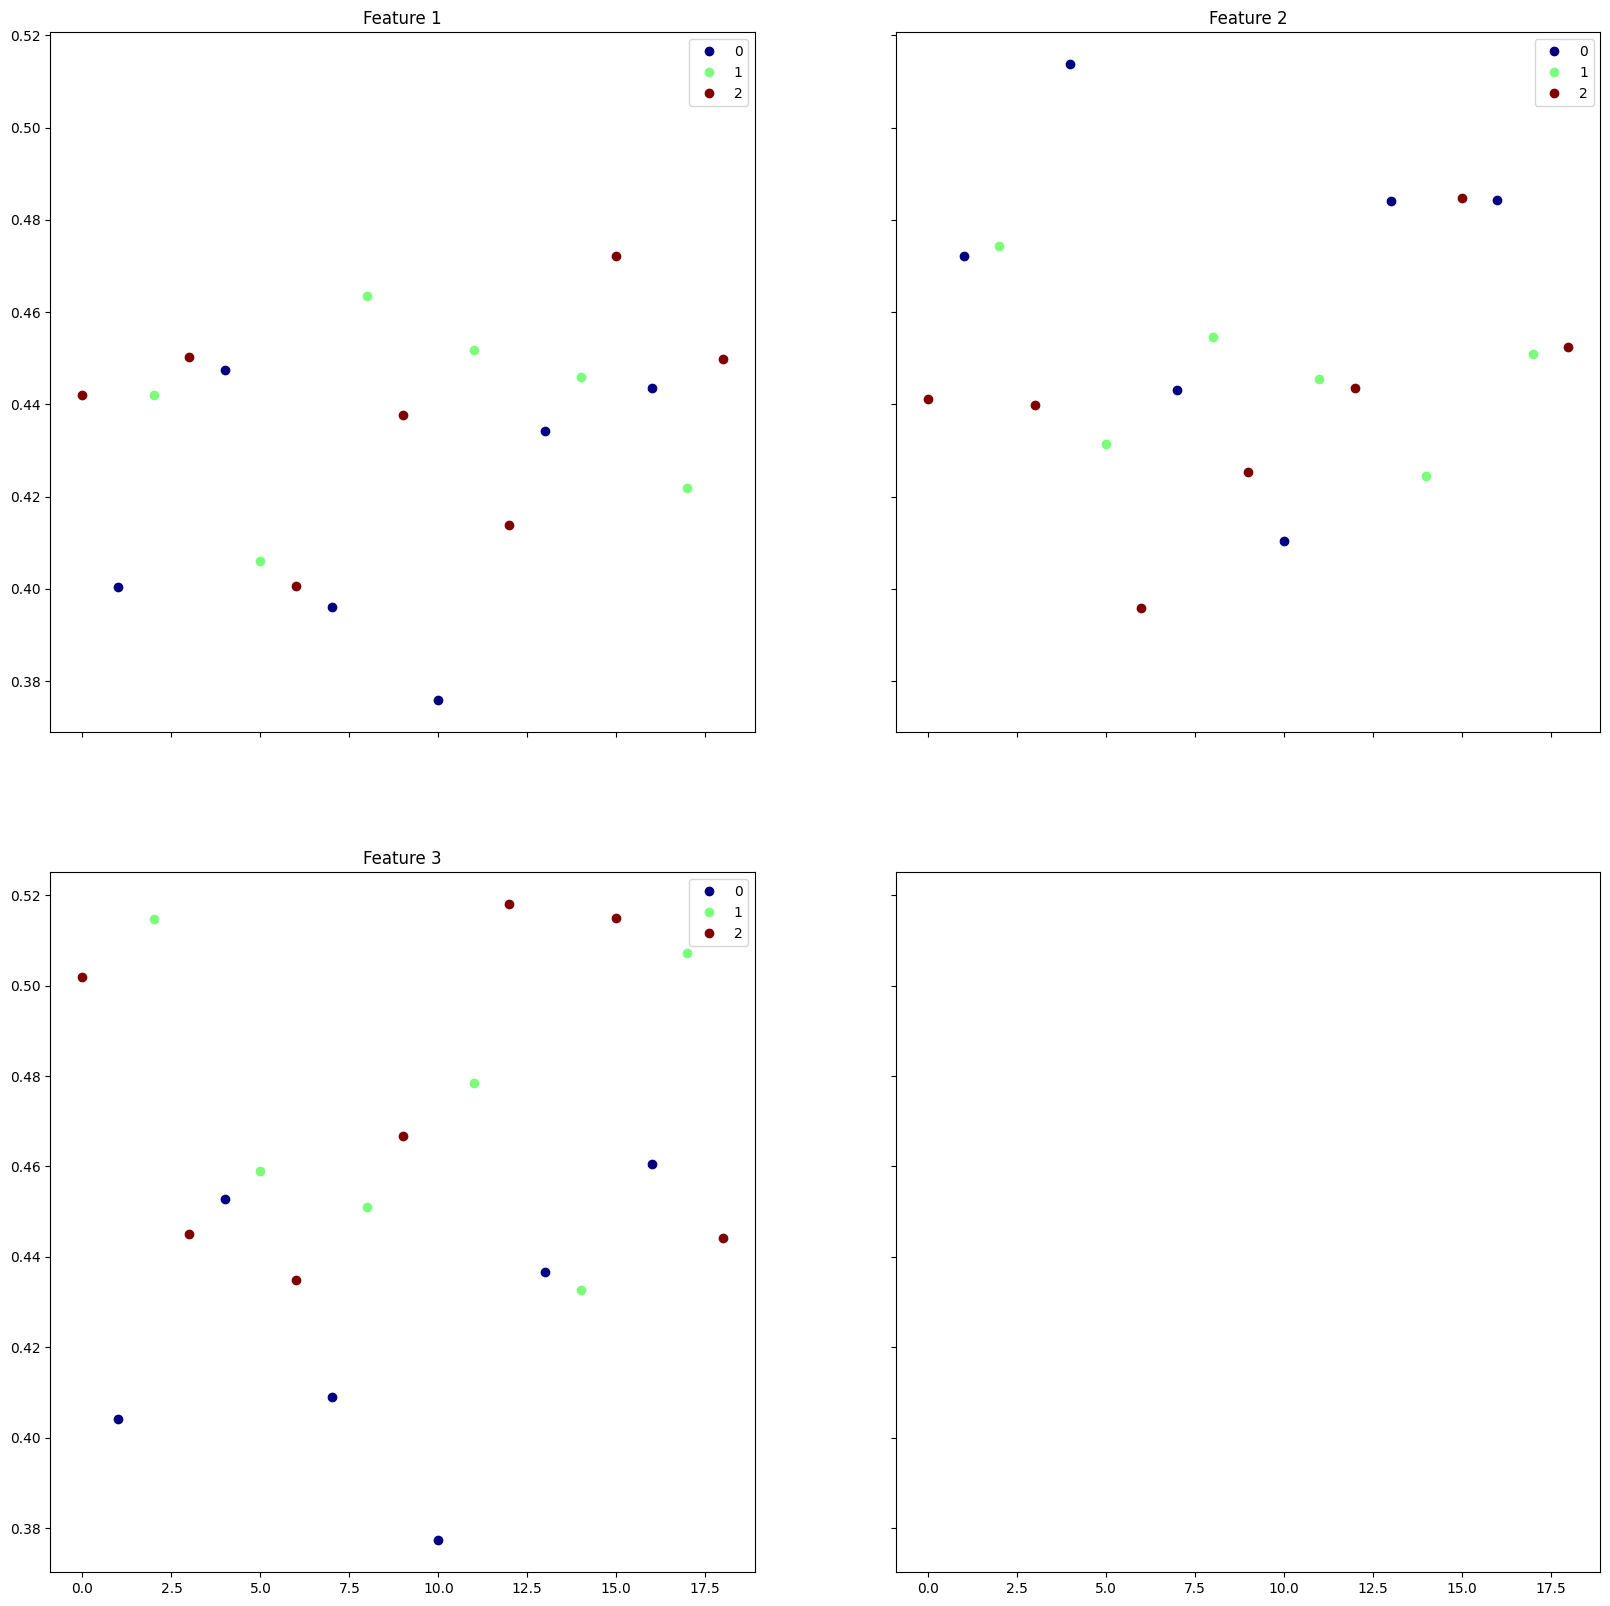

In [11]:
warmup = 2 * M

states = results[:-1]
target = timeseries[1:]
print(states.shape)
states = states[warmup:]
target = target[warmup:]
model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
train_x, test_x, train_y, test_y = train_test_split(states, target, test_size=0.33)

model.fit(train_x, train_y)
print(f'Score of model: {model.score(test_x, test_y)}')
QRP.utilities.result_plotter(states, target)


In [ ]:
num_predictions = 5

for idx in range(num_predictions):
    circ = subsystems[idx]
    

for idx in tqdm(range(num_subsystems)):
    for l in range(2*M, len(timeseries)):
        
        qr = QuantumRegister(len(mem_qubits))
        cr = ClassicalRegister(len(mem_qubits))
        circ = QuantumCircuit(qr, cr)
        circ.reset(qr)

        for i, time in enumerate(timeseries[l-2*M:l]):
            circ.unitary(ops[time], qr, label=f'{time}')
            circ.measure(0, 0)
            if np.random.random() > d:
                circ.reset(qr)
        circ.measure(qr, cr)

        counts = QRP.utilities.simulate(circ, shots=SHOTS)#.get_counts()
        # counts = [elem.replace(" ", "") for elem in counts]
        res = memory_to_mean(counts, 1).ravel()
        results[l] += res.copy()
